In [1]:
!pip install shapely
!pip install geopandas
!pip install folium
!pip install googletrans

     |████████████████████████████████| 1.0 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 55 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 972 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 53 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 7.8 MB/s  eta 0:00:01
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=8b4073d2e72722efc52aba7331863c5c403d6fd0a0f13e3caa735c5c76821eb2
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [2]:
#import Libraries
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium

In [3]:
# The code was removed by Watson Studio for sharing.

,id,zip,province,district,lat,lng
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679
1,2,10300,กรุงเทพมหานคร,ดุสิต,13.772694,100.509926
2,3,10530,กรุงเทพมหานคร,หนองจอก,13.855988,100.861969
3,4,10500,กรุงเทพมหานคร,บางรัก,13.726240,100.526799
4,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643


In [4]:
#Processing Data
geo_data.rename(columns = {'zip': 'postcode'}, inplace = True)
geo_data['coordinates'] = list(zip(geo_data['lat'], geo_data['lng']))
geo_data['coordinates'] = geo_data['coordinates'].apply(Point)
geo_data.head()

,id,postcode,province,district,lat,lng,coordinates
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679,POINT (13.7560243 100.4986793)
1,2,10300,กรุงเทพมหานคร,ดุสิต,13.772694,100.509926,POINT (13.7726943 100.5099262)
2,3,10530,กรุงเทพมหานคร,หนองจอก,13.855988,100.861969,POINT (13.8559883 100.8619689)
3,4,10500,กรุงเทพมหานคร,บางรัก,13.726240,100.526799,POINT (13.7262395 100.5267991)
4,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643,POINT (13.864387 100.6146434)


In [5]:
# import map rendering library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON 
import geopy

# use geopy to obtain latitude/longitude of Toronto.
# coordinates will be used for map visualization

address = 'Bangkok, Thailand'

geolocator = geopy.Nominatim(user_agent="ny_explorer", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok 13.7538929, 100.8160803.


In [6]:
# create map of Toronto using latitude and longitude values
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map based on coordinates of postcode
for lat, lng, neighbourhood in zip(geo_data['lat'], geo_data['lng'], geo_data['district']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok)  
    
map_bangkok

In [7]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF' # your Foursquare ID
CLIENT_SECRET = 'H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23' # your Foursquare Secret
VERSION = '20161225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF
CLIENT_SECRET:H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23


In [8]:
# define limit = 50 (limit to 50 venues only) & radius = 5000 (meters)
LIMIT = 50
radius = 5000

location_list = [] # initiate a list to store data from Foursquare API requests

for neighbourhood, latitude, longitude in zip(geo_data.district, geo_data.lat, geo_data.lng):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
    data = requests.get(url).json()
    #print(data)
    # use len() to check if any data within "items" (len = 0 if nothing)
    length = len(data['response']['groups'][0]['items'])
    if length == 0:
        continue # skip the row if nothing is found
    else:
        venue = data['response']['groups'][0]['items'][0]['venue']
        
        # extract info within 'venue'
        name = venue['name']
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        cat = venue['categories'][0]['name']
        
        location_list.append([(neighbourhood, latitude, longitude, name, lat, lon, cat)])

In [9]:
# create data frame based on 'Location_list'

temp = pd.DataFrame(x for row in location_list for x in row)
temp.columns = ['district','N_Latitude','N_Longitude','Venue','V_Latitude','V_Longitude','category']
temp.head()

#print("{} nearby locations downloaded for {} neighbourhood.".format(len(temp.Venue), len(geo_data.district)))

,district,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude,category
0,พระนคร,13.756024,100.498679,Mont Nom Sod (มนต์นมสด),13.753972,100.501317,Bakery
1,ดุสิต,13.772694,100.509926,Amphorn Satharn Villa (พระที่นั่งอัมพรสถาน),13.772462,100.511298,Palace
2,หนองจอก,13.855988,100.861969,สวนสาธารณะหนองจอก,13.853778,100.859002,Park
3,บางรัก,13.726240,100.526799,Scarlett,13.726056,100.525880,Wine Bar
4,บางเขน,13.864387,100.614643,Starbucks (สตาร์บัคส์),13.862239,100.612988,Coffee Shop


In [10]:
#define food related location list and filter the data

restaurant_cat = ['Bakery', 'Coffee Shop', 'Chinese Restaurant',
       'Ice Cream Shop', 'Hotpot Restaurant', 'Thai Restaurant', 'Bar',
       'Noodle House', 'Japanese Restaurant', 'BBQ Joint', 'Shabu-Shabu Restaurant',
       'Café', 'Beer Bar', 'Asian Restaurant', 'Halal Restaurant', 'Steakhouse',
       'Fast Food Restaurant']
temp_1 = temp[temp.category.isin(restaurant_cat)]
temp_1

,district,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude,category
0,พระนคร,13.756024,100.498679,Mont Nom Sod (มนต์นมสด),13.753972,100.501317,Bakery
4,บางเขน,13.864387,100.614643,Starbucks (สตาร์บัคส์),13.862239,100.612988,Coffee Shop
7,ป้อมปราบศัตรูพ่าย,13.751495,100.510848,Tongue-Fun Ice-Cream (ทังฟันไอศกรีม),13.748918,100.514700,Ice Cream Shop
8,พระโขนง,13.691065,100.614025,Summer Ice ไอศครีมเกล็ดหิมะ,13.691580,100.614757,Ice Cream Shop
9,มีนบุรี,13.813049,100.731339,MK (เอ็มเค),13.807679,100.726588,Hotpot Restaurant
10,ลาดกระบัง,13.727734,100.748631,คูณสิน เป็ดย่างอบน้ำผึ้ง,13.722463,100.752902,Thai Restaurant
11,ยานนาวา,13.717126,100.515133,Jack's Bar,13.722377,100.513611,Bar
12,สัมพันธวงศ์,13.738009,100.509850,Lim Lao Sa (ลิ้มเล่าซา),13.737511,100.508520,Noodle House
18,ตลิ่งชัน,13.773318,100.428418,ข้าวแกงปักษ์ใต้ ขนมจีนเมืองคอน,13.770137,100.443770,Thai Restaurant
19,บางกอกน้อย,13.760409,100.471573,Starbucks (สตาร์บัคส์),13.762176,100.472202,Coffee Shop


In [11]:
#Create one-hot encoding table
cat = pd.get_dummies(temp_1.category) # one hot encoding with get_dummies()
df_01 = pd.concat([temp_1[['district']], cat], axis=1) # combine neighbourhood & category tables
#df_01 = pd.crosstab(temp_1.district, temp_1.category)
df_01.head()

,district,BBQ Joint,Bakery,Bar,Beer Bar,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,พระนคร,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,บางเขน,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,ป้อมปราบศัตรูพ่าย,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,พระโขนง,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,มีนบุรี,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Cluster Analysis

In [12]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [13]:
# Pre-process the data
df_02 = df_01.drop('district', axis=1)
df_02.head()

,BBQ Joint,Bakery,Bar,Beer Bar,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
n_group = 6 # we will group neighbourhoods into 6 clusters

# run k-means clustering
kmeans = KMeans(n_clusters=n_group, random_state=0).fit(df_02)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_01.insert(1, 'label', kmeans.labels_)

df_01.head() 


,district,label,BBQ Joint,Bakery,Bar,Beer Bar,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,พระนคร,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,บางเขน,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,ป้อมปราบศัตรูพ่าย,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,พระโขนง,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,มีนบุรี,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [15]:
#Add geodata to the dataframe

bkk_merged = pd.merge(geo_data, df_01, on='district', how='right')
bkk_merged.head()

,id,postcode,province,district,lat,lng,coordinates,label,BBQ Joint,Bakery,...,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679,POINT (13.7560243 100.4986793),0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643,POINT (13.864387 100.6146434),2,0,0,...,1,0,0,0,0,0,0,0,0,0
2,8,10100,กรุงเทพมหานคร,ป้อมปราบศัตรูพ่าย,13.751495,100.510848,POINT (13.7514954 100.5108479),1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,9,10260,กรุงเทพมหานคร,พระโขนง,13.691065,100.614025,POINT (13.6910654 100.614025),1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10,10510,กรุงเทพมหานคร,มีนบุรี,13.813049,100.731339,POINT (13.8130488 100.731339),5,0,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
#Plot Cluster Map for Examination

from matplotlib import cm, colors
import folium

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bkk_merged['lat'], bkk_merged['lng'], bkk_merged['district'], bkk_merged['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [17]:
def plot_hot_code(cat):
    bar_temp = bkk_merged.loc[bkk_merged['label'] == cat, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]
    bar_temp.drop(['postcode', 'lng', 'coordinates', 'label'], axis=1, inplace=True)
    bar_temp1 = bar_temp.sum()
    bar_temp1.plot.bar()


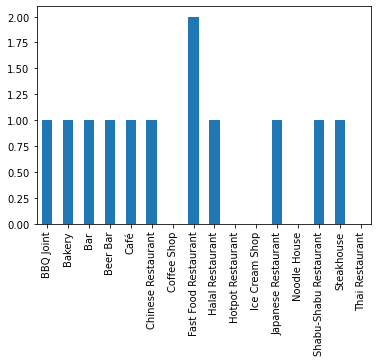

In [18]:
plot_hot_code(0)

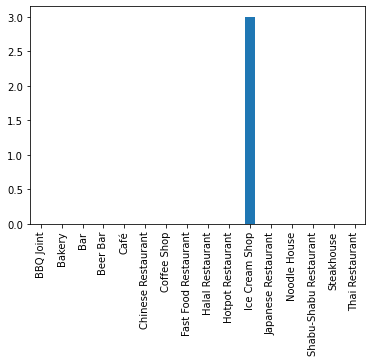

In [19]:
plot_hot_code(1)

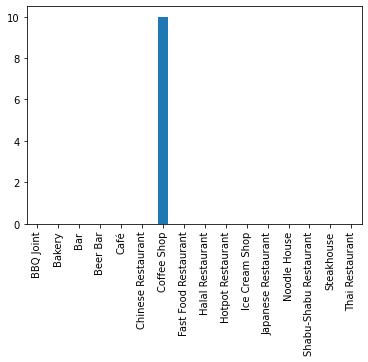

In [20]:
plot_hot_code(2)

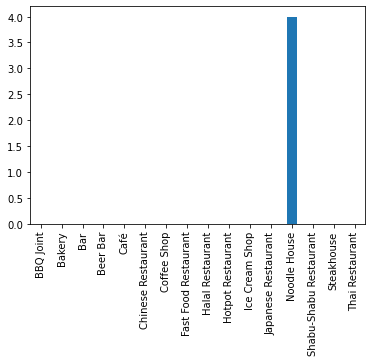

In [21]:
plot_hot_code(3)

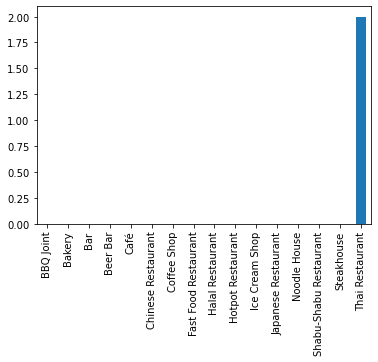

In [22]:
plot_hot_code(4)

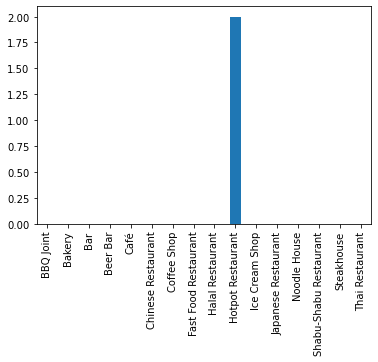

In [23]:
plot_hot_code(5)

In [74]:
#Import Google Translate to translate Thai district name into English

from googletrans import Translator
translator = Translator()

# Final product: 
Add label to cluster

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
cluster_name = ['All kind of food', 'Icecream Shop', 'Coffee Shop', 'Noodle House', 'Thai restaurant', 'Hotpot Restaurant']
markers_colors = []
for lat, lon, poi, cluster in zip(bkk_merged['lat'], bkk_merged['lng'], bkk_merged['district'], bkk_merged['label']):
    district = translator.translate(poi).text
    label = folium.Popup(district + '\n Best for ' + cluster_name[cluster-1], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [88]:
def district_cluster(cluster):
    clustertemp = bkk_merged[bkk_merged['label']== cluster]
    clustertemp = clustertemp[['district']]
    return clustertemp

In [89]:
c = district_cluster(0)
print(translator.translate(cluster_name[0]).text)
c   

All kind of food


,district
0,พระนคร
6,ยานนาวา
13,บางพลัด
16,บางซื่อ
19,คลองเตย
20,สวนหลวง
23,ราชเทวี
24,ลาดพร้าว
29,คลองสามวา
30,ทวีวัฒนา


In [63]:
c = district_cluster(1)
print(cluster_name[1])
c

noodle house


,district
2,ป้อมปราบศัตรูพ่าย
3,พระโขนง
18,ประเวศ


In [64]:
c = district_cluster(2)
print(cluster_name[2])
c

coffee shop


,district
1,บางเขน
9,บางกอกน้อย
10,ภาษีเจริญ
11,หนองแขม
14,บึงกุ่ม
21,จอมทอง
22,ดอนเมือง
25,บางแค
26,สายไหม
28,สะพานสูง


In [65]:
c = district_cluster(3)
print(cluster_name[3])
c

Thai restaurant


,district
7,สัมพันธวงศ์
15,สาทร
17,บางคอแหลม
27,คันนายาว


In [66]:
c = district_cluster(4)
print(cluster_name[4])
c

icecream Shop


,district
5,ลาดกระบัง
8,ตลิ่งชัน


In [90]:
c = district_cluster(5)
print(cluster_name[5])
c

Hotpot Restaurant


,district
4,มีนบุรี
12,ราษฎร์บูรณะ
